# GPyOpt: armed bandits optimization

### Written by Javier Gonzalez, Amazon Reseach Cambridge, UK.


*Last updated Monday, 22 May 2016.*

In this notebook we will see how to do armed bandits optimization with GPyOpt. To do this will use data of weather forecasts at weather stations across more that 10.000 locations in the United States. The project [OpenWeatherMap project](http://openweathermap.org/) provides an API service to download this information and at that [dataset](https://github.com/WeatherStudy/weather_study) it is possible to find the weather forecasts for these stations. In this notebook we will use the file target_day_20140422.dat that contains the weather forecasts for each station in the United States for the April 22, 2014. The latitude and longitude of the stations is available as well as the forecasts for the next 7 days.

We start by loading the packages that we will need in out analysis.

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np 
import GPyOpt

Next, we load the data.

In [2]:
filename='./data/target_day_20140422.dat'
f = open(filename, 'r')
contents = f.readlines()

Now, we process the dataset. We selected only the data corresponding to the day April 22, 2014 and we remove the stations in Alaska and the US islands. The fist part of the next cell was taken from this [matplotlib tutorial](https://github.com/ginaschmalzle/pyladies_matplotlib_ipython_notebooks/blob/master/Matplotlib_tutorial.ipynb).

In [3]:
## Create a dictionary for the forecasted
forecast_dict = {}
for line in range(1, len(contents)):
    line_split = contents[line].split(' ')
    try:
        forecast_dict[line_split[0], line_split[1]][line_split[2]] = {'MaxT':float(line_split[3]),
                                                                      'MinT':float(line_split[4][:-1])}
    except:
        forecast_dict[line_split[0], line_split[1]] = {}
        forecast_dict[line_split[0], line_split[1]][line_split[2]] = {'MaxT':float(line_split[3]),
                                                                      'MinT':float(line_split[4][:-1])}
keys = forecast_dict.keys()
day_out = '0'  # 0-7
temp = 'MaxT'  # MaxT or MinT
temperature = []; lat = []; lon = []
for key in keys:
    temperature.append(float(forecast_dict[key][day_out][temp]))
    lat.append(float(key[0]))
    lon.append(float(key[1]))
    
## Create numpy arrays for the analyisis and remove Alaska and the islands
lon = np.array(lon)
lat = np.array(lat)
sel = np.logical_and(np.logical_and(lat>24,lat<51),np.logical_and(lon> -130, lon <-65))
stations_coordinates_all = np.array([lon,lat]).T
stations_maxT_all = np.array([temperature]).T
stations_coordinates = stations_coordinates_all[sel,:]
stations_maxT = stations_maxT_all[sel,:]

In [4]:
# Check the total number of stations.
stations_maxT.shape[0]

11585

The array *stations_coordinates* contains the longitude and latitude of the weather stations and *stations_maxT* contains the maximum temperature value recorded in those locations on the April 22, 2014. Next we make a plot of all available stations.

(-128, -65)

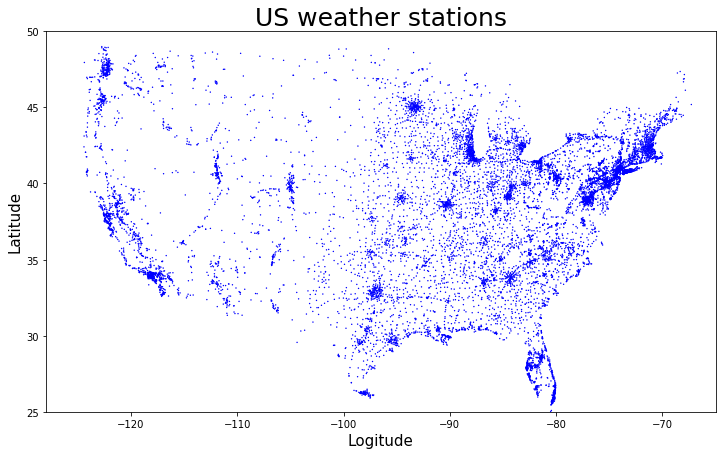

In [5]:
plt.figure(figsize=(12,7))
sc = plt.scatter(stations_coordinates[:,0],stations_coordinates[:,1], c='b', s=2, edgecolors='none')
plt.title('US weather stations',size=25)
plt.xlabel('Logitude',size=15)
plt.ylabel('Latitude',size=15)
plt.ylim((25,50))
plt.xlim((-128,-65))

Our goal is to find the **coldest stations** in this map using the **minumum number of queries**. We use the full dataset to create this objective function.

In [6]:
#  Class that defines the function to optimize given the available locations
class max_Temp(object):
    def __init__(self,stations_coordinates,stations_maxT):
        self.stations_coordinates = stations_coordinates
        self.stations_maxT = stations_maxT

    def f(self,x):
        return np.dot(0.5*(self.stations_coordinates == x).sum(axis=1),self.stations_maxT)[:,None]

The class *max_Temp* returns the temperature of each station everytime is queried with the coordinates of one of the available stations. To use it for this optimization example we create and instance of it.

In [7]:
# Objective function given the current inputs
func = max_Temp(stations_coordinates,stations_maxT)

Our design space is now the coordinates of the weather stations. We crete it:

In [8]:
domain = [{'name': 'stations', 'type': 'bandit', 'domain':stations_coordinates }]  # armed bandit with the locations

Now we create the GPyOpt object. We will initilize the process with 50 stations, assume that the data are noisy, and we won't normalize the outputs. A seed is used for reproducibility

In [9]:
from numpy.random import seed
seed(123)
myBopt = GPyOpt.methods.BayesianOptimization(f=func.f,            # function to optimize       
                                             domain=domain,        
                                             initial_design_numdata = 5,
                                             acquisition_type='EI',
                                             exact_feval = True,
                                             normalize_Y = False,
                                             optimize_restarts = 10,
                                             acquisition_weight = 2,
                                             de_duplication = True) 

In [10]:
myBopt.model.model

We run the optimization for a maximum of 50 iterations

In [11]:
# Run the optimization
max_iter = 50     # evaluation budget
myBopt.run_optimization(max_iter) 

AttributeError: 'BayesianOptimization' object has no attribute 'evaluate_constraint'

GPyOpt prints a message to say that the optimization was stopped because the same location was selected twice. Let's have a look to the results. We plot the map with the true temperature of the stations, the coldest one and the best found location. 

In [ ]:
plt.figure(figsize=(15,7))
jet = plt.cm.get_cmap('jet')
sc = plt.scatter(stations_coordinates[:,0],stations_coordinates[:,1], c=stations_maxT[:, 0], vmin=0, vmax =35, cmap=jet, s=3, edgecolors='none')
cbar = plt.colorbar(sc, shrink = 1)
cbar.set_label(temp)
plt.plot(myBopt.x_opt[0],myBopt.x_opt[1],'ko',markersize=10, label ='Best found')
plt.plot(myBopt.X[:,0],myBopt.X[:,1],'k.',markersize=8, label ='Observed stations')
plt.plot(stations_coordinates[np.argmin(stations_maxT),0],stations_coordinates[np.argmin(stations_maxT),1],'k*',markersize=15, label ='Coldest station')
plt.legend()
plt.ylim((25,50))
plt.xlim((-128,-65))

plt.title('Max. temperature: April, 22, 2014',size=25)
plt.xlabel('Longitude',size=15)
plt.ylabel('Latitude',size=15)
plt.text(-125,28,'Total stations =' + str(stations_maxT.shape[0]),size=20)
plt.text(-125,26.5,'Sampled stations ='+ str(myBopt.X.shape[0]),size=20)

The coldest and the selected locations are very close. Note that, in total, only three evaluations were necesary to find this stations. Of course, different results can be found with different initilizations, models, acquisition, etc. To finish, we plot the value of the temperature in the best found station over the histogram of all temperatures.

In [ ]:
plt.figure(figsize=(8,5))
xx= plt.hist(stations_maxT,bins =50)
plt.title('Distribution of max. temperatures',size=25)
plt.vlines(min(stations_maxT),0,1000,lw=3,label='Coldest station')
plt.vlines(myBopt.fx_opt,0,1000,lw=3,linestyles=u'dotted',label='Best found')
plt.legend()
plt.xlabel('Max. temperature',size=15)
plt.xlabel('Frequency',size=15)

We see that it is indeed one of the coldest stations.